# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import gatspy

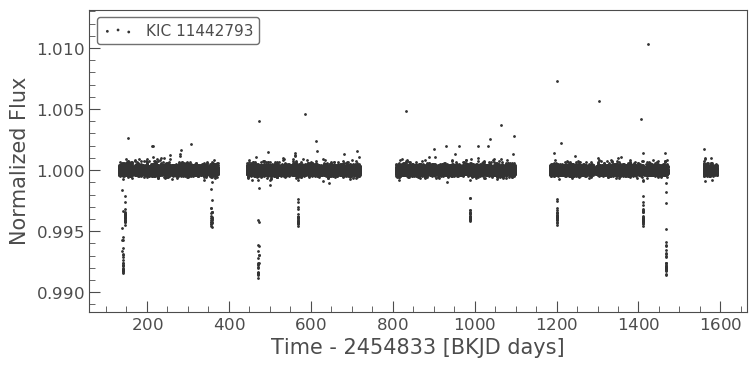

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

In [3]:
from matplotlib.ticker import AutoMinorLocator
def periodogram(model,xlim):
    periods = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), 901)
    power = model.periodogram(periods)
    fig, ax = plt.subplots(figsize=(12,2))
    ax.plot(periods, power)
    ax.set_xscale('log')
    ax.set_xlim(xlim)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='major', length=10,direction ='in')
    ax.tick_params(which='minor', length=5,direction ='in')
    fig.tight_layout()

def LCplot(model,period,ax):
    tfit = np.linspace(0, period, int(period)+1)
    yfit = model.predict(tfit,period)
    ax.plot(t%period, f, linestyle='None', marker='.',ms=1)
    ax.plot(tfit, yfit, linestyle='-', color='k', alpha=1,lw=1,label='gatspy predict')
    ax.set_ylim([0.99,1.01])
    ax.set_xlabel('days')  
    ax.set_ylabel('flux')
    ax.set_title(f'Period = {period:.2f} days')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='major', length=10,direction ='in')
    ax.tick_params(which='minor', length=5,direction ='in')
    ax.legend()
    return ax

def periodsearch(start,delT,xlim):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))
    for i in range(3):
        for j in range(3):
            period = start+delT*(i*3+j)
            ax[i,j] = LCplot(model,period,ax[i,j])
            ax[i,j].set_xlim(xlim)

    fig.tight_layout()

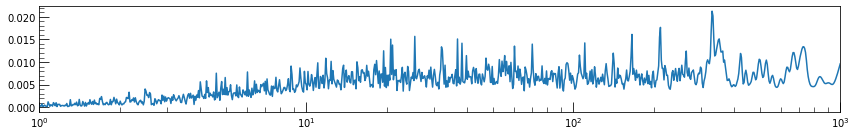

In [4]:
t = clc.time
f = clc.flux

model = gatspy.periodic.LombScargle(Nterms=10)
model.fit(t,f)

xlim = [1,1000]
periodogram(model,xlim)

The periodogram shows that there is a strong peak between 300 and 400.

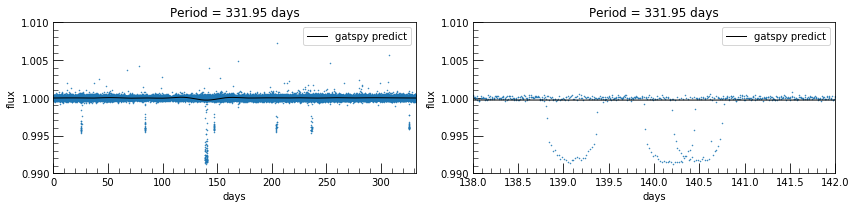

In [5]:
model.optimizer.set(period_range=(300,400),quiet=True)
period = model.best_period
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0] = LCplot(model,period,ax[0])
ax[0].set_xlim([0,period])
ax[1] = LCplot(model,period,ax[1])
ax[1].set_xlim([138,142])
fig.tight_layout()

It looks like that T = 331.95 is close to, but not the true period for one of the planets. Let's search and verify the true period visually using folded light curve.

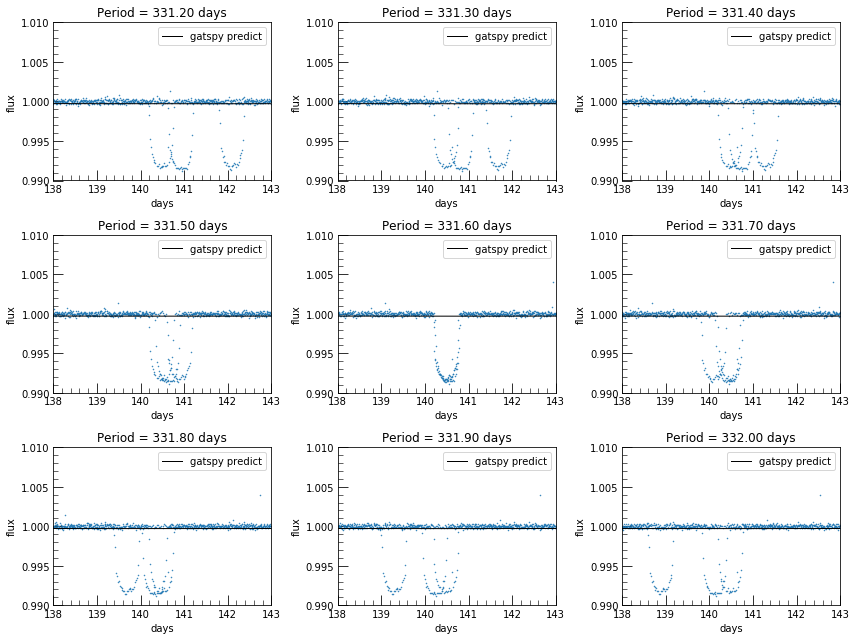

In [6]:
periodsearch(331.2,0.1,(138,143))

So T = 331.6 is verified via folded light curve.

In [7]:
period = 331.6
t_transit = (140.2,140.8)
n = int((max(t)-min(t))/period)+1
tmark = t_transit[0] + period*np.arange(n)
delT = t_transit[1]-t_transit[0]
a = np.array([False,]*(len(t)))
for i in range(n):
    a = [any(pair) for pair in zip (a,(t>tmark[i])&(t<tmark[i]+delT),(t>tmark[i]+period/2)&(t<tmark[i]+delT+period/2))]

a = [not i for i in a]

t = t[a]
f = f[a]

Remove T = 331.6 signals. Then redo the periodogram with more Fourier modes to sharpen the peaks.

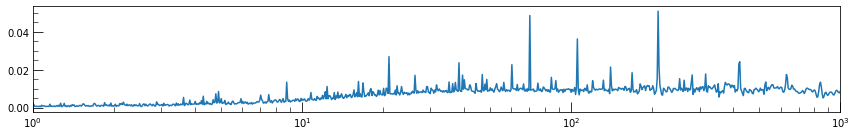

In [8]:
model_r = gatspy.periodic.LombScargle(Nterms=25)
model_r.fit(t,f)

periodogram(model_r,xlim)

There is a strong peak just beyond 200.

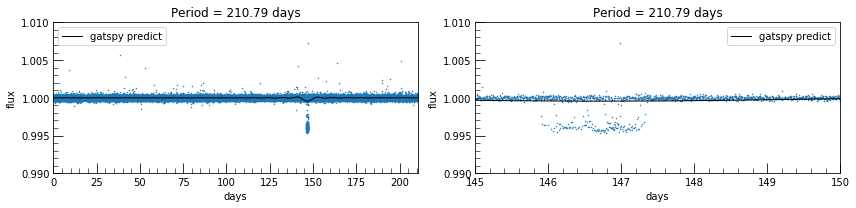

In [9]:
model_r.optimizer.set(period_range=(200,250),quiet=True)
period = model_r.best_period
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0] = LCplot(model_r,period,ax[0])
ax[0].set_xlim([0,period])
ax[1] = LCplot(model_r,period,ax[1])
ax[1].set_xlim([145,150])
fig.tight_layout()

It looks like that T = 210.79 is a close solution. Let's search and verify the true period visually again.

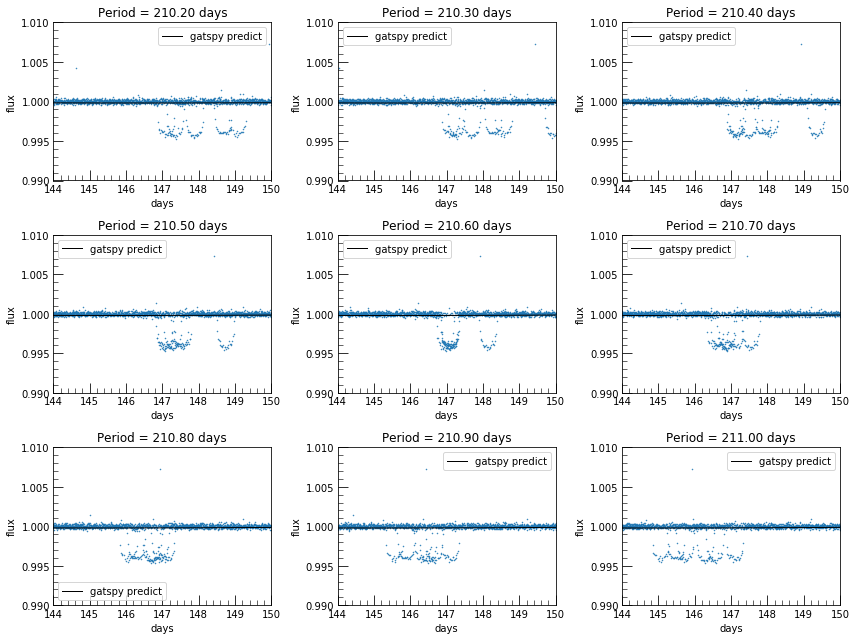

In [10]:
periodsearch(210.2,0.1,[144,150])

T = 210.6 appears to be the next period for the planets. But there is one dip misaligned to all the others by roughly one day.

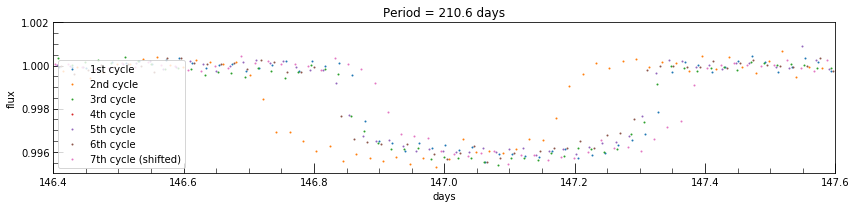

In [11]:
period = 210.6
labels = ['1st cycle','2nd cycle','3rd cycle','4th cycle','5th cycle','6th cycle','7th cycle (shifted)']
fig, ax = plt.subplots(figsize=(12,3))
for i in range(7):
    a = (t>period*i)&(t<period*(i+1))
    if (i == 6):
        plt.plot(t[a]%period - 1, f[a], linestyle='None', marker='.',ms=2,label = labels[i])
    else:   
        plt.plot(t[a]%period, f[a], linestyle='None', marker='.',ms=2,label = labels[i])
    plt.xlim([146.4,147.6])

ax.set_xlabel('days')  
ax.set_ylabel('flux')
ax.set_title(f'Period = {period:.1f} days')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='major', length=10,direction ='in')
ax.tick_params(which='minor', length=5,direction ='in')
ax.set_ylim([0.995,1.002])
ax.legend(loc=3)
fig.tight_layout()

These dips seem to agree each other if we shift the last cycle by one day.

In [12]:
period = 210.6
t_transit = (146.7,147.4)
n = int((max(t)-min(t))/period)+1
tmark = t_transit[0] + period*np.arange(n)
delT = t_transit[1]-t_transit[0]
a = np.array([False,]*(len(t)))
for i in range(n):
    if (i==(n-1)):
        a = [any(pair) for pair in zip (a,(t>tmark[i]+1)&(t<tmark[i]+1+delT),(t>tmark[i]+1+period/2)&(t<tmark[i]+1+delT+period/2))]
    else:
        a = [any(pair) for pair in zip (a,(t>tmark[i])&(t<tmark[i]+delT),(t>tmark[i]+period/2)&(t<tmark[i]+delT+period/2))]

a = [not i for i in a]

t = t[a]
f = f[a]

Remove T = 210.6 signals. Then do the periodogram again for the residual.

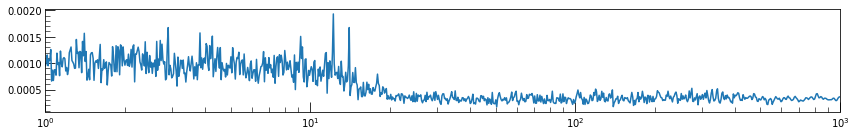

In [13]:
model_rr = gatspy.periodic.LombScargle(Nterms=25)
model_rr.fit(t,f)

xlim = [1,1000]
periodogram(model_rr,xlim)

Potential peaks around 10? Let's zoom in.

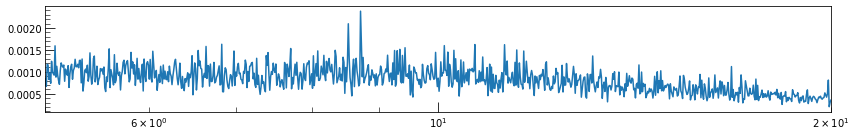

In [14]:
xlim = [5,20]
periodogram(model_rr,xlim)

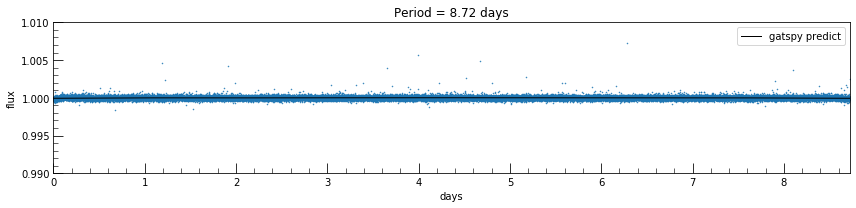

In [15]:
model_rr.optimizer.set(period_range=(5,20),quiet=True)
period = model_rr.best_period
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,3))
ax = LCplot(model_rr,period,ax)
ax.set_xlim([0,period])
fig.tight_layout()

gatspy nicely gives me the third period T = 8.72, but I don't see any strong dip in the folded light curve.

In summary, I find three periods for exoplanets: 331.6, 210.6, and 8.72 days. All of them agree the Kepler-90 data in The Exoplanet Archive.